In [19]:
import pandas as pd
import numpy as np
import os
import getpass
import re
import nltk
import tqdm
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import swifter
import matplotlib as plt
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras import optimizers
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [3]:
df = pd.read_csv("Merged_Finall.csv")
df["Date"] = pd.to_datetime(df["Date"])
df

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,timestamp,FinalScore
0,1,Bitcoin,BTC,2013-04-29,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,2013-04-29,0.456971
1,2,Bitcoin,BTC,2013-04-30,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,2013-04-30,0.522668
2,3,Bitcoin,BTC,2013-05-01,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,2013-05-01,0.651334
3,4,Bitcoin,BTC,2013-05-02,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,2013-05-02,0.546912
4,5,Bitcoin,BTC,2013-05-03,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,2013-05-03,0.959801
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,2396,Bitcoin,BTC,2019-11-19,8408.516128,8099.963369,8305.134291,8206.145918,2.108361e+10,1.481784e+11,2019-11-19,266.234714
2396,2397,Bitcoin,BTC,2019-11-20,8237.239874,8010.511901,8203.613180,8027.268243,2.076430e+10,1.449627e+11,2019-11-20,10.221575
2397,2398,Bitcoin,BTC,2019-11-21,8110.098131,7597.381608,8023.644687,7642.749945,2.251424e+10,1.380319e+11,2019-11-21,-8503.435071
2398,2399,Bitcoin,BTC,2019-11-22,7697.382714,6936.706599,7643.569425,7296.577568,3.424232e+10,1.317918e+11,2019-11-22,15.649639


In [15]:
df["prev_close"] = df["Close"].shift(+1)
df = df.dropna()
df

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,timestamp,FinalScore,prev_close
1,2,Bitcoin,BTC,2013-04-30,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,2013-04-30,0.522668,144.539993
2,3,Bitcoin,BTC,2013-05-01,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,2013-05-01,0.651334,139.000000
3,4,Bitcoin,BTC,2013-05-02,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,2013-05-02,0.546912,116.989998
4,5,Bitcoin,BTC,2013-05-03,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,2013-05-03,0.959801,105.209999
5,6,Bitcoin,BTC,2013-05-04,115.000000,92.500000,98.099998,112.500000,0.000000e+00,1.250317e+09,2013-05-04,0.945516,97.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,2396,Bitcoin,BTC,2019-11-19,8408.516128,8099.963369,8305.134291,8206.145918,2.108361e+10,1.481784e+11,2019-11-19,266.234714,8309.285983
2396,2397,Bitcoin,BTC,2019-11-20,8237.239874,8010.511901,8203.613180,8027.268243,2.076430e+10,1.449627e+11,2019-11-20,10.221575,8206.145918
2397,2398,Bitcoin,BTC,2019-11-21,8110.098131,7597.381608,8023.644687,7642.749945,2.251424e+10,1.380319e+11,2019-11-21,-8503.435071,8027.268243
2398,2399,Bitcoin,BTC,2019-11-22,7697.382714,6936.706599,7643.569425,7296.577568,3.424232e+10,1.317918e+11,2019-11-22,15.649639,7642.749945


In [16]:
split_date = '2018-08-01'
df_train = df.loc[df.Date <= split_date].copy()
df_test = df.loc[df.Date > split_date].copy()

In [18]:
X_train = df_train[["FinalScore", "prev_close", "Volume"]]
y_train = df_train["Close"]

X_test = df_test[["FinalScore", "prev_close", "Volume"]]
y_test = df_test["Close"]

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

In [23]:
df_test['Prediction'] = reg.predict(X_test)
df_test = df_test.drop(columns="MW_Prediction")
df_test

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,timestamp,FinalScore,prev_close,Prediction
1921,1922,Bitcoin,BTC,2018-08-02,7712.770000,7523.440000,7634.190000,7567.150000,4.214110e+09,1.300521e+11,2018-08-02,27.623565,7624.910000,7681.250488
1922,1923,Bitcoin,BTC,2018-08-03,7562.140000,7328.650000,7562.140000,7434.390000,4.627150e+09,1.277858e+11,2018-08-03,4.906260,7567.150000,7041.616211
1923,1924,Bitcoin,BTC,2018-08-04,7497.490000,6984.070000,7438.670000,7032.850000,4.268390e+09,1.208997e+11,2018-08-04,166.311141,7434.390000,6985.199707
1924,1925,Bitcoin,BTC,2018-08-05,7102.770000,6940.700000,7031.080000,7068.480000,3.679110e+09,1.215261e+11,2018-08-05,1343.727618,7032.850000,7054.077148
1925,1926,Bitcoin,BTC,2018-08-06,7166.550000,6890.540000,7062.940000,6951.800000,3.925900e+09,1.195315e+11,2018-08-06,1264.987785,7068.480000,6950.625488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,2396,Bitcoin,BTC,2019-11-19,8408.516128,8099.963369,8305.134291,8206.145918,2.108361e+10,1.481784e+11,2019-11-19,266.234714,8309.285983,8162.984863
2396,2397,Bitcoin,BTC,2019-11-20,8237.239874,8010.511901,8203.613180,8027.268243,2.076430e+10,1.449627e+11,2019-11-20,10.221575,8206.145918,7969.887695
2397,2398,Bitcoin,BTC,2019-11-21,8110.098131,7597.381608,8023.644687,7642.749945,2.251424e+10,1.380319e+11,2019-11-21,-8503.435071,8027.268243,7886.934570
2398,2399,Bitcoin,BTC,2019-11-22,7697.382714,6936.706599,7643.569425,7296.577568,3.424232e+10,1.317918e+11,2019-11-22,15.649639,7642.749945,7808.998535


In [24]:
df_actual = df_test["Close"]
df_pred = df_test["Prediction"]

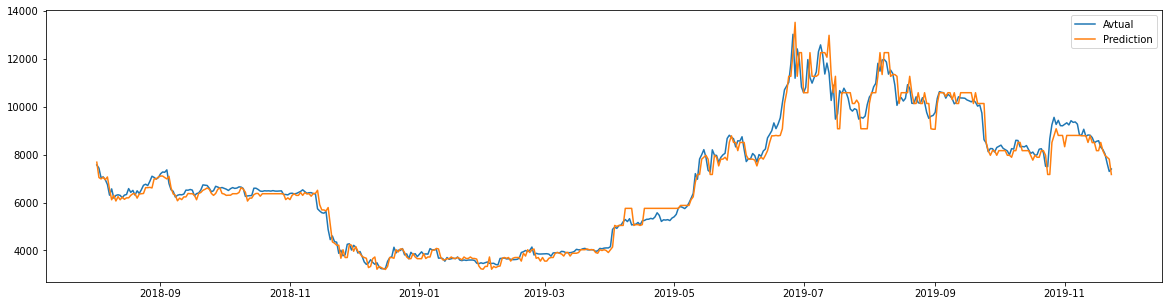

In [25]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(df_test["Date"], df_test["Close"], label = "Avtual")
plt.plot(df_test["Date"], df_test["Prediction"], label = "Prediction")
plt.legend()